# Assignment 2: Predicting Fast Growth of Firms
## Data Management, Sample Design & Feature Engineering

**Dataset:** bisnode-firms panel (cs_bisnode_panel.csv)  
**Approach:** Closely follows the ch17 firm-exit data preparation cpde, adapted for a fast-growth target.

---

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 150)

## 0. Set Up Paths

In [2]:
base_dir = os.path.join(os.getcwd(), "..")  # assumes notebook runs from code/

data_raw   = os.path.join(base_dir, "data", "raw")
data_clean = os.path.join(base_dir, "data", "clean")
output_dir = os.path.join(base_dir, "output")


## 1. Load Raw Data

In [3]:
data = pd.read_csv(os.path.join(data_raw, "cs_bisnode_panel.csv"))
print(f"Raw panel shape: {data.shape}")
print(f"Years available: {sorted(data['year'].unique())}")
print(f"Unique firms: {data['comp_id'].nunique()}")

Raw panel shape: (287829, 48)
Years available: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Unique firms: 46412


In [4]:
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,net_dom_sales,net_exp_sales,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,wages,D,balsheet_flag,balsheet_length,balsheet_notfullyear,year,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,NaN,1229.629639,218.518524,0.0,4355.555664,2911.111084,38222.222656,NaN,NaN,22222.222656,62.962963,62751.851562,881.481506,1388.888916,1229.629639,NaN,NaN,0,364,0,2005,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,NaN,725.925903,996.296326,0.0,7225.925781,5896.296387,38140.742188,NaN,NaN,23844.445312,755.555542,64625.925781,1637.036987,1388.888916,725.925903,NaN,NaN,0,364,0,2006,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,NaN,1322.222168,570.370361,0.0,7951.852051,177.777771,40174.074219,NaN,NaN,22262.962891,0.000000,65100.000000,1633.333374,1388.888916,1322.222168,NaN,NaN,0,364,0,2007,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,NaN,1022.222229,714.814819,0.0,5233.333496,1392.592651,54274.074219,NaN,NaN,21107.408203,0.000000,78085.187500,1725.925903,1481.481445,1022.222229,NaN,NaN,0,365,0,2008,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,NaN,814.814819,-11044.444336,0.0,3259.259277,11.111111,41755.554688,NaN,NaN,13237.037109,-11074.074219,45388.890625,-9348.148438,1481.481445,814.814819,NaN,NaN,0,364,0,2009,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


## 2. Panel Preparation

### 2.1 Drop variables with many NAs and filter years

Following the exit-prediction pipeline, we drop columns that are largely missing
and keep the 2010–2015 panel as instructed.

In [5]:
# Drop variables with too many NAs (same as exit prep)
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

# Keep 2010-2015 panel as required by the assignment
data = data.query("year >= 2010 & year <= 2015")
print(f"Panel shape after filtering: {data.shape}")
print(f"Years: {sorted(data['year'].unique())}")

Panel shape after filtering: (167606, 43)
Years: [2010, 2011, 2012, 2013, 2014, 2015]


### 2.2 Fill all firm–year combinations

Ensure every firm has a row for every year in the panel.
Originally missing combinations get NaN in all other columns. Ensuring firm exist can be tracked.

In [6]:
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)
print(f"Balanced panel shape: {data.shape}")

Balanced panel shape: (236250, 43)


## 3. Label Engineering – Defining the Fast-Growth Target

### 3.1 Growth measure: sales-based approach

We measure firm growth using **total sales revenue** (`sales`). This is the most natural
choice in this dataset for several reasons: sales are reported for virtually every firm-year
observation, they directly reflect market demand for the firm's products or services, and they
are the standard top-line measure used in corporate finance to gauge firm scale.

The alternative would be **employment-based growth** (using `labor_avg`, the annual average
number of employees). However, this variable is noisy and has a high share of missing values
in the Bisnode data, making it unreliable as a basis for the target. Asset-based growth is
also possible but less informative for SMEs where balance-sheet items are often lumpy and
driven by accounting choices rather than real expansion.

Concretely, the **growth variable** is the **2-year log change in total sales**:

$$\text{growth}_i = \ln(\text{sales}_{i,2014}) - \ln(\text{sales}_{i,2012})$$

Using log differences means the variable approximates a percentage growth rate and treats
proportional gains and losses symmetrically (e.g. a doubling and a halving are equal in
absolute value). This is standard in the empirical corporate-finance literature.

### 3.2 Why a two-year horizon (2012 → 2014)?

We measure fast growth over a **two-year window (2012 → 2014)** rather than a single year.
A two-year horizon smooths out short-term revenue volatility (e.g. one-off contracts, seasonal effects)
and better captures sustained, structural growth trajectories that are more meaningful from a
corporate-finance and investment perspective.
Using a single year (2012 → 2013) would risk labelling firms as "fast growers" based on
temporary spikes rather than genuine expansion.

### 3.3 Target definition

We convert the continuous growth variable into a **binary target** (`fast_growth`):

| Firm status in 2014 | Coding |
|---|---|
| Firm alive with sales in 2014, and 2-year log sales growth > 75th percentile of growth distribution | `fast_growth = 1` |
| Firm alive with sales in 2014, but growth ≤ 75th percentile | `fast_growth = 0` |
| Firm exits by 2014 (no positive sales) | `fast_growth = 0` |

**Rationale:** From a business perspective (e.g. an investor screening deal flow, or a bank
evaluating credit expansion potential), firms that cease to operate are clearly not fast growers.
Including them as zeros avoids sample-selection bias that would arise if we conditioned on survival.
We use the 75th percentile of the growth distribution among survivors to capture the top-performing
quartile — a common benchmark in growth-equity screening.

**Alternatives considered for the threshold:**
- *Absolute threshold* (e.g. >20% annualized growth ≈ 44% cumulative): transparent but arbitrary,
  does not adapt to the data.
- *Median split*: would label ~50% of survivors as "fast growth", diluting the concept of truly
  exceptional performance.

In [7]:
# 3.3  Construct status_alive 
# A firm is "alive" in a given year if it has positive, non-missing sales
data["status_alive"] = ((data["sales"] > 0) & (data["sales"].notna())).astype(int)

In [8]:
# 3.4  Get sales two years ahead for each firm 
# Sort to ensure correct shifting
data = data.sort_values(["comp_id", "year"]).reset_index(drop=True)

data["sales_2y_ahead"] = data.groupby("comp_id")["sales"].shift(-2)
data["status_alive_2y"] = data.groupby("comp_id")["status_alive"].shift(-2)

In [9]:
# 3.5  Compute log sales and 2-year log growth
# Handle negative / zero sales (same cleaning as exit prep)
data["sales"] = np.where(data["sales"] < 0, 1, data["sales"])

data["ln_sales"] = np.where(
    data["sales"] > 0,
    np.log(data["sales"]),
    np.where(data["sales"].isna(), np.nan, 0),
)

data["sales_mil"] = data["sales"] / 1_000_000
data["sales_mil_log"] = np.where(
    data["sales"] > 0,
    np.log(data["sales"] / 1_000_000),
    np.where(data["sales"].isna(), np.nan, 0),
)

# 2-year forward log sales growth (the basis for our target)
data["ln_sales_2y_ahead"] = np.where(
    data["sales_2y_ahead"] > 0,
    np.log(data["sales_2y_ahead"]),
    np.nan,
)
data["ln_sales_growth_2y"] = data["ln_sales_2y_ahead"] - data["ln_sales"]

In [10]:
# 3.6  One-year lagged sales change (FEATURE, not target) 
data["d1_sales_mil_log"] = (
    data["sales_mil_log"]
    - data.groupby("comp_id")["sales_mil_log"].shift(1)
)

In [11]:
# 3.7  Age and "new firm" flag (same as exit prep)
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    (data["age"] <= 1) | (data["balsheet_notfullyear"] == 1),
    1,
    np.where(data["age"].isna(), np.nan, 0),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

## 4. Sample Design

Following the exit-prediction pipeline:
- **Cross-section:** year = 2012, status_alive = 1
- **Sales filter:** firms with annual sales between €1 000 and €10 million
- **Target window:** growth measured through 2014

In [12]:
# Filter to 2012 cross-section of alive firms
data = data.query("year == 2012 & status_alive == 1").copy()
print(f"Firms alive in 2012: {len(data)}")

# Filter by sales range (same as exit prep)
data = data.query("sales_mil <= 10 & sales_mil >= 0.001").copy()
print(f"After sales filter (€1K – €10M): {len(data)}")

Firms alive in 2012: 22845
After sales filter (€1K – €10M): 21723


In [13]:
# 4.1  Define the fast_growth target 
# Firms that exit by 2014 → fast_growth = 0
# Among survivors: fast_growth = 1 if growth > 75th percentile

# Check how many firms survive vs exit
data["survived_to_2014"] = (
    (data["status_alive_2y"] == 1) & (data["sales_2y_ahead"] > 0)
).astype(int)

print(f"Survived to 2014: {data['survived_to_2014'].sum()} "
      f"({data['survived_to_2014'].mean()*100:.1f}%)")
print(f"Exited by 2014:   {(data['survived_to_2014'] == 0).sum()} "
      f"({(1 - data['survived_to_2014'].mean())*100:.1f}%)")

Survived to 2014: 17255 (79.4%)
Exited by 2014:   4468 (20.6%)


In [14]:
# Growth distribution among survivors
survivors = data.loc[data["survived_to_2014"] == 1, "ln_sales_growth_2y"]
print("Distribution of 2-year log sales growth among survivors:")
print(survivors.describe().round(3))
print(f"\n75th percentile (threshold): {survivors.quantile(0.75):.4f}")

Distribution of 2-year log sales growth among survivors:
count    17255.000
mean         0.078
std          1.106
min        -10.778
25%         -0.230
50%          0.111
75%          0.453
max          8.536
Name: ln_sales_growth_2y, dtype: float64

75th percentile (threshold): 0.4532


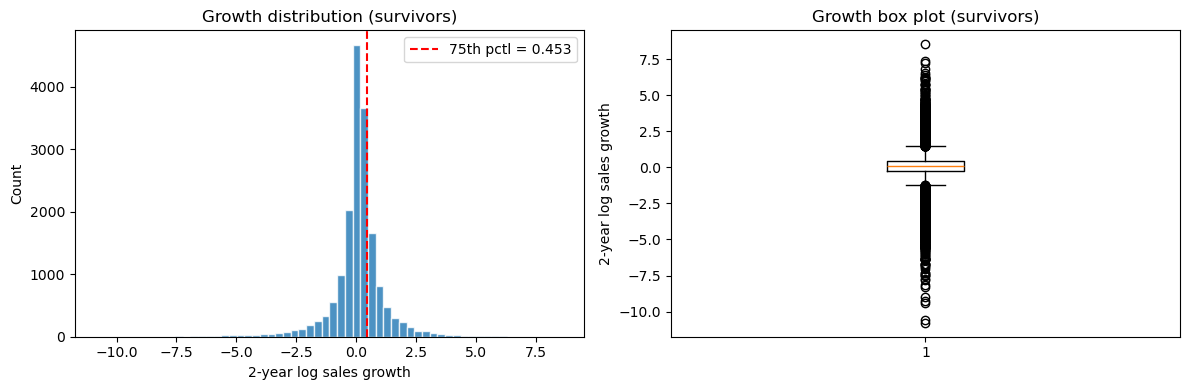

In [15]:
# Visualise the growth distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(survivors.dropna(), bins=60, edgecolor="white", alpha=0.8)
threshold_val = survivors.quantile(0.75)
axes[0].axvline(threshold_val, color="red", linestyle="--",
                label=f"75th pctl = {threshold_val:.3f}")
axes[0].set_xlabel("2-year log sales growth")
axes[0].set_ylabel("Count")
axes[0].set_title("Growth distribution (survivors)")
axes[0].legend()

# Box plot
axes[1].boxplot(survivors.dropna(), vert=True)
axes[1].set_ylabel("2-year log sales growth")
axes[1].set_title("Growth box plot (survivors)")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "growth_distribution.png"),
            dpi=150, bbox_inches="tight")
plt.show()

 The 75th percentile (0.453) and mean (0.078) look close in raw numbers, but
  that's driven by the heavy tails inflating the std to 1.106. The distribution
  isn't narrow — it's fat-tailed with extreme outliers on both sides. Most firms
   cluster around modest growth while a few shrink or grow dramatically.

  In economic terms they're actually quite different:
  - Mean growth: e^0.078 - 1 ≈ 8% cumulative over 2 years
  - 75th pctl growth: e^0.453 - 1 ≈ 57% cumulative over 2 years

  A firm growing 57% in two years versus 8% is a meaningful distinction.

In [16]:
# Define fast_growth
growth_threshold = survivors.quantile(0.75)

data["fast_growth"] = np.where(
    (data["survived_to_2014"] == 1)
    & (data["ln_sales_growth_2y"] > growth_threshold),
    1,
    0,
)

print(f"\nGrowth threshold (75th pctl of survivors): {growth_threshold:.4f}")
print(f"\nFast growth distribution:")
print(data["fast_growth"].value_counts())
print(f"\nShare of fast-growth firms: {data['fast_growth'].mean()*100:.1f}%")


Growth threshold (75th pctl of survivors): 0.4532

Fast growth distribution:
fast_growth
0    17409
1     4314
Name: count, dtype: int64

Share of fast-growth firms: 19.9%


In [17]:
# 4.2  Check industry composition for Task 2 
# The assignment requires separate analysis for manufacturing vs services
print("Broad industry categories ('ind'):")
print(data["ind"].value_counts())

Broad industry categories ('ind'):
ind
3.0    14977
2.0     5638
1.0      452
Name: count, dtype: int64


## 5. Feature Engineering

We engineer features **identically** to the exit-prediction code.
All features are measured as of 2012 (the prediction date). The logic:

- **Financial ratios:** P&L items scaled by sales; balance-sheet items scaled by total assets.
- **Winsorisation & flags:** cap extreme values at ±1 and create indicator flags.
- **Human capital:** CEO age, gender, foreign management, number of employees.
- **Firm demographics:** age, industry, region, urban status.
- **Growth momentum:** lagged 1-year sales change (d1_sales_mil_log).

See reasoning for variable selection at the end of the notebook.

### 5.1  Industry categories

In [18]:
# Recode detailed industry into broader categories (same as exit prep)
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

print("Industry category counts:")
print(data.groupby("ind2_cat")["comp_id"].count())

Industry category counts:
ind2_cat
20.0       50
26.0     1080
27.0      660
28.0     1954
29.0      287
30.0      168
32.0      148
33.0     1944
40.0      208
55.0     2266
56.0    12711
60.0      242
99.0        5
Name: comp_id, dtype: int64


### 5.2  Firm characteristics

In [19]:
data["age2"] = data["age"] ** 2

data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

### 5.3  Financial ratios

We construct two sets of ratios, exactly as in the exit-prediction prep:

- **P&L ratios** (`_pl`): divide profit-and-loss items by total sales → measure operational structure.
- **Balance-sheet ratios** (`_bs`): divide balance-sheet items by total assets → measure financial structure.

These normalised ratios allow comparison across firms of different sizes.

In [20]:
# Total assets
# Assets cannot be negative – floor at 0, flag problems
data["flag_asset_problem"] = np.where(
    (data["intang_assets"] < 0) | (data["curr_assets"] < 0) | (data["fixed_assets"] < 0),
    1, 0,
)
data["flag_asset_problem"] = np.where(
    data["intang_assets"].isna() | data["curr_assets"].isna() | data["fixed_assets"].isna(),
    np.nan, data["flag_asset_problem"],
)

data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"]   = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"]  = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
print("Total assets summary:")
print(data["total_assets_bs"].describe().round(1))

Total assets summary:
count        21713.0
mean        252588.9
std        1383198.0
min              0.0
25%           6466.7
50%          23829.6
75%          93463.0
max      104683276.3
Name: total_assets_bs, dtype: float64


In [21]:
# P&L ratios (divided by sales)
pl_names = [
    "extra_exp", "extra_inc", "extra_profit_loss", "inc_bef_tax",
    "inventories", "material_exp", "profit_loss_year", "personnel_exp",
]

data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

# Balance-sheet ratios (divided by total assets) 
bs_names = [
    "intang_assets", "curr_liab", "fixed_assets", "liq_assets",
    "curr_assets", "share_eq", "subscribed_cap", "tang_assets",
]

data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

### 5.4  Winsorisation & flags

Variables are capped at sensible ranges and flags are created to capture
extreme or erroneous values. This is identical to the exit-prediction pipeline:

- **Non-negative ratios** (e.g. material expenses / sales): capped at [0, 1], flags for violations.
- **Signed ratios** (e.g. profit/loss / sales): capped at [-1, 1], flags + quadratic terms.

In [22]:
# Variables that cannot be negative
zero = [
    "extra_exp_pl", "extra_inc_pl", "inventories_pl", "material_exp_pl",
    "personnel_exp_pl", "curr_liab_bs", "fixed_assets_bs", "liq_assets_bs",
    "curr_assets_bs", "subscribed_cap_bs", "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [23]:
# Variables that can be positive or negative
anyof = [
    "extra_profit_loss_pl", "inc_bef_tax_pl",
    "profit_loss_year_pl", "share_eq_bs",
]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where(data[anyof] < -1, -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where(data[anyof] > 1, 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [24]:
# Summary of all flag variables after cleanup
flag_cols = [col for col in data.columns if "flag" in col]

flag_summary = pd.DataFrame({
    "n_flagged": data[flag_cols].sum(),
    "pct_flagged": (data[flag_cols].mean() * 100).round(2),
})
flag_summary = flag_summary.sort_values("n_flagged", ascending=False)

print(f"Total flag variables retained: {len(flag_cols)}\n")
print(flag_summary.to_string())

Total flag variables retained: 36

                                n_flagged  pct_flagged
extra_profit_loss_pl_flag_zero    18886.0        86.94
curr_liab_bs_flag_high             6170.0        28.42
share_eq_bs_flag_low               4907.0        22.60
material_exp_pl_flag_high          3505.0        16.16
subscribed_cap_bs_flag_high        2700.0        12.43
inc_bef_tax_pl_flag_low            1569.0         7.22
profit_loss_year_pl_flag_low       1567.0         7.22
personnel_exp_pl_flag_high          903.0         4.16
profit_loss_year_pl_flag_zero       679.0         3.13
inventories_pl_flag_high            494.0         2.28
share_eq_bs_flag_high               202.0         0.93
inc_bef_tax_pl_flag_high            108.0         0.50
profit_loss_year_pl_flag_high        90.0         0.41
share_eq_bs_flag_zero                69.0         0.32
extra_inc_pl_flag_high               57.0         0.26
extra_profit_loss_pl_flag_high       51.0         0.23
balsheet_flag                 

 There are some high-rate flags like the _flag_zero variables (                     extra_profit_loss_pl_flag_zero, inc_bef_tax_pl_flag_zero), that's expected. Many small firms legitimately report zero extra income, zero extra profit/loss, etc.

In [25]:
# Drop flag columns with zero variance
flag_columns = [col for col in data.columns if "flag" in col]
zero_var = data[flag_columns].std()[(data[flag_columns].std() == 0)].index.tolist()
if zero_var:
    data = data.drop(columns=zero_var)
    print(f"Dropped {len(zero_var)} zero-variance flag columns: {zero_var}")
else:
    print("No zero-variance flag columns to drop.")

Dropped 6 zero-variance flag columns: ['fixed_assets_bs_flag_high', 'curr_assets_bs_flag_high', 'intang_assets_bs_flag_high', 'fixed_assets_bs_flag_error', 'curr_assets_bs_flag_error', 'intang_assets_bs_flag_error']


### 5.5  CEO & human capital variables

In [26]:
# CEO age: winsorise and impute
data["ceo_age"] = data["year"] - data["birth_year"]

data["flag_low_ceo_age"]  = (data["ceo_age"] < 25).astype(int)
data["flag_high_ceo_age"] = (data["ceo_age"] > 75).astype(int)
data["flag_miss_ceo_age"] = (data["ceo_age"].isna()).astype(int)

data["ceo_age"] = data["ceo_age"].clip(lower=25, upper=75)
data["ceo_age"] = data["ceo_age"].fillna(data["ceo_age"].mean())

data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

print("CEO age summary:")
print(data["ceo_age"].describe().round(1))

CEO age summary:
count    21723.0
mean        46.5
std          9.8
min         25.0
25%         40.0
50%         46.5
75%         52.0
max         75.0
Name: ceo_age, dtype: float64


In [27]:
# Number of employees: impute missing with mean, keep flag
data["labor_avg_mod"] = data["labor_avg"].fillna(data["labor_avg"].mean())
data["flag_miss_labor_avg"] = data["labor_avg"].isna().astype(int)

data = data.drop(columns=["labor_avg"])

print(f"Missing labor_avg imputed: {data['flag_miss_labor_avg'].sum()} "
      f"({data['flag_miss_labor_avg'].mean()*100:.1f}%)")

Missing labor_avg imputed: 3154 (14.5%)


### 5.6  Sales variables

In [28]:
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

In [29]:
# Sales change (1-year lag) – feature engineering 
data["flag_low_d1_sales_mil_log"]  = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5, -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

### 5.7  Convert categorical variables

In [30]:
data["urban_m"]   = data["urban_m"].astype("category")
data["ind2_cat"]  = data["ind2_cat"].astype("category")

data["fast_growth_f"] = data["fast_growth"].astype("category")
data["fast_growth_f"] = data["fast_growth_f"].cat.rename_categories(
    ["no_fast_growth", "fast_growth"]
)

### 5.8  Drop observations with missing key variables

In [31]:
n_before = len(data)
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
n_after = len(data)

# Drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

print(f"Dropped {n_before - n_after} rows with missing key variables.")
print(f"Final sample size: {n_after}")

Dropped 2687 rows with missing key variables.
Final sample size: 19036


## 6. Define Variable Sets for Modelling

We define variable groups that mirror the exit-prediction setup.
These will be used in the prediction notebook to build logit, LASSO, and random forest models.

In [32]:
# Raw financial variables 
rawvars = [
    "curr_assets", "curr_liab", "extra_exp", "extra_inc",
    "extra_profit_loss", "fixed_assets", "inc_bef_tax", "intang_assets",
    "inventories", "liq_assets", "material_exp", "personnel_exp",
    "profit_loss_year", "sales", "share_eq", "subscribed_cap",
]

# Balance-sheet quality flags 
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]

# Engineered financial ratios 
engvar = [
    "total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
    "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs",
    "extra_exp_pl", "extra_inc_pl", "extra_profit_loss_pl",
    "inc_bef_tax_pl", "inventories_pl", "material_exp_pl",
    "profit_loss_year_pl", "personnel_exp_pl",
]

engvar2 = [
    "extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad", "share_eq_bs_quad",
]

# Flag variables (auto-detected) 
engvar3 = [
    col for col in data.columns
    if col.endswith("flag_low") or col.endswith("flag_high")
    or col.endswith("flag_error") or col.endswith("flag_zero")
]

# Growth momentum (1-year lagged change)
d1 = [
    "d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log",
]

# Human capital
hr = [
    "female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
    "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
    "flag_miss_labor_avg", "foreign_management",
]

# Firm demographics 
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

# Interactions (for logit / LASSO) 
interactions1 = [
    "C(ind2_cat)*age", "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod", "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age", "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female", "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age", "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

print(f"Variable group sizes:")
print(f"  rawvars:         {len(rawvars)}")
print(f"  engvar:          {len(engvar)}")
print(f"  engvar2:         {len(engvar2)}")
print(f"  engvar3 (flags): {len(engvar3)}")
print(f"  d1:              {len(d1)}")
print(f"  hr:              {len(hr)}")
print(f"  qualityvars:     {len(qualityvars)}")

Variable group sizes:
  rawvars:         16
  engvar:          15
  engvar2:         4
  engvar3 (flags): 28
  d1:              4
  hr:              9
  qualityvars:     3


## 7. Variable Selection – Reasoning

### Why reuse the exit-prediction feature set for growth prediction?

The financial and organisational variables that predict firm distress (exit) are, to a large extent,
the **same variables** that predict firm growth — but the mechanisms work in the opposite direction.
This is well established in the corporate-finance literature on firm dynamics (e.g. Jovanovic 1982,
Cooley & Quadrini 2001):

**Financial structure and profitability** (`profit_loss_year_pl`, `inc_bef_tax_pl`, `share_eq_bs`,
`curr_assets_bs`): Profitable firms with healthy balance sheets have more internal resources
to fund expansion (retained earnings, stronger collateral for external financing).
The same ratios that signal distress when low signal growth capacity when high.

**Liquidity and leverage** (`liq_assets_bs`, `curr_liab_bs`): Adequate liquidity allows firms
to seize growth opportunities (invest in new equipment, hire staff, enter new markets).
Overleveraged firms are constrained — they service debt instead of investing.

**Growth momentum** (`d1_sales_mil_log_mod`): Past sales growth is one of the strongest
predictors of future growth due to demand persistence, learning effects, and market-position
feedback loops. This variable captures momentum.

**Human capital** (`ceo_age`, `female`, `foreign_management`, `labor_avg_mod`):
Management characteristics proxy for strategic orientation, risk appetite, and access to
networks. Younger CEOs and foreign managers may pursue more aggressive growth strategies.
Workforce size captures current scale and operational capacity.

**Firm demographics** (`age`, `ind2_cat`, `urban_m`, `m_region_loc`):
Young firms grow faster on average (Gibrat's law violations), but with more variance.
Industry and location capture structural growth rates and market opportunities.

### What changes relative to exit prediction?

We keep the **same features** but the **model coefficients will flip or change magnitude**.
For example, high profitability ratios will have a negative coefficient for exit but a positive
coefficient for fast growth. The flags and quadratic terms allow the models to capture
non-linearities (e.g. both very low and very high sales changes may signal unusual activity).

The interaction terms (industry × firm characteristics) are particularly important because
growth dynamics differ substantially across sectors — a 20% growth rate is exceptional in
mature manufacturing but common in tech-oriented services.

## 8. Descriptive Statistics

In [33]:
# Target variable summary
print("=== Fast Growth Target ===")
print(data["fast_growth"].value_counts())
print(f"\nShare: {data['fast_growth'].mean()*100:.1f}%")
print(f"\n=== By industry (broad) ===")
print(data.groupby("ind")["fast_growth"].agg(["mean", "count"]).round(3))

=== Fast Growth Target ===
fast_growth
0    15393
1     3643
Name: count, dtype: int64

Share: 19.1%

=== By industry (broad) ===
      mean  count
ind              
1.0  0.287    407
2.0  0.208   5155
3.0  0.182  13474


In [34]:
# Key variable distributions by fast_growth status
key_vars = [
    "sales_mil_log", "d1_sales_mil_log_mod", "profit_loss_year_pl",
    "age", "ceo_age", "labor_avg_mod", "share_eq_bs",
]

print("Mean values by fast_growth status:\n")
print(data.groupby("fast_growth")[key_vars].mean().round(3).T)

Mean values by fast_growth status:

fast_growth                0       1
sales_mil_log         -2.951  -3.507
d1_sales_mil_log_mod  -0.045  -0.063
profit_loss_year_pl   -0.119  -0.161
age                    9.137   6.864
ceo_age               46.771  44.989
labor_avg_mod          0.657   0.502
share_eq_bs            0.029   0.078


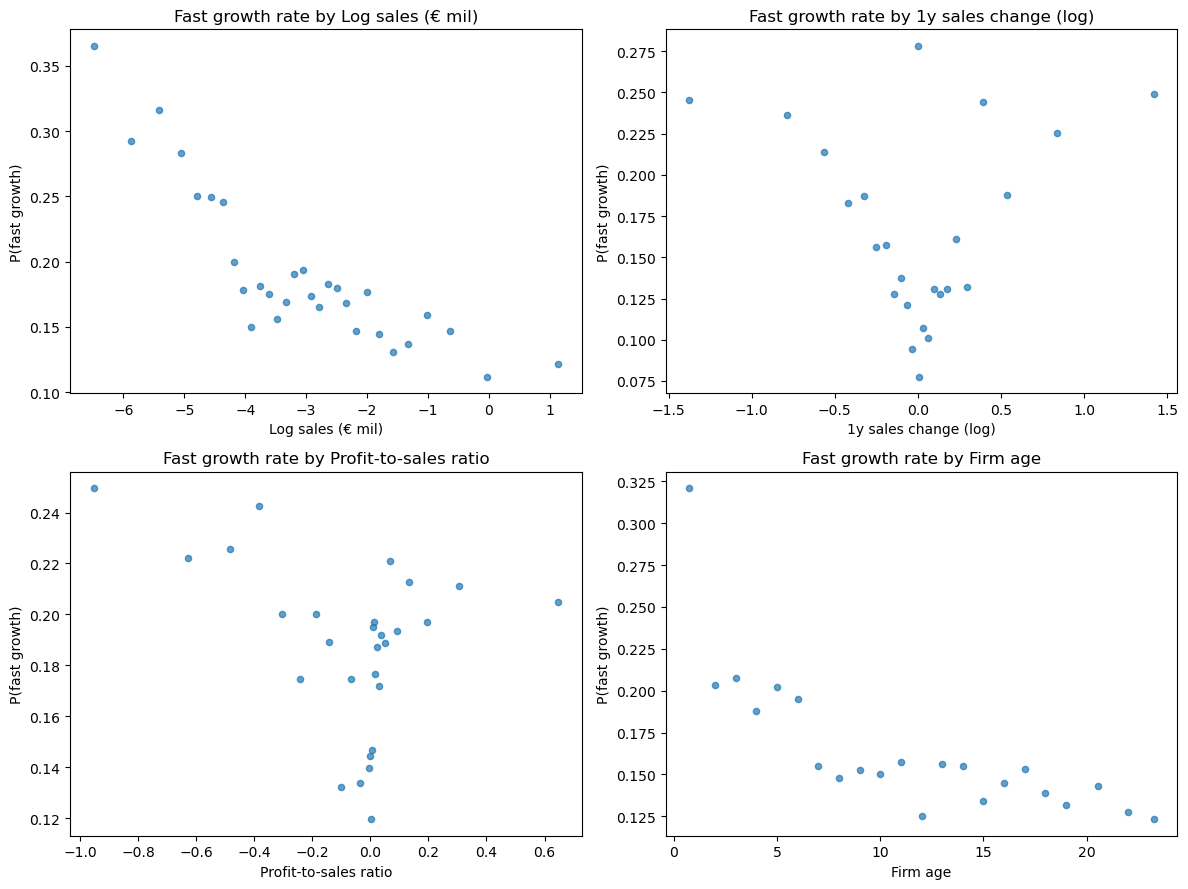

In [35]:
# Lowess-style smoothed plots: fast_growth vs key features
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

for ax, var, label in zip(
    axes.flat,
    ["sales_mil_log", "d1_sales_mil_log_mod", "profit_loss_year_pl", "age"],
    ["Log sales (€ mil)", "1y sales change (log)",
     "Profit-to-sales ratio", "Firm age"],
):
    temp = data[[var, "fast_growth"]].dropna().copy()
    temp["bin"] = pd.qcut(temp[var], q=30, duplicates="drop")
    binned = temp.groupby("bin")["fast_growth"].mean().reset_index()
    binned["x"] = temp.groupby("bin")[var].mean().reset_index()[var]
    ax.scatter(binned["x"], binned["fast_growth"], s=20, alpha=0.7)
    ax.set_xlabel(label)
    ax.set_ylabel("P(fast growth)")
    ax.set_title(f"Fast growth rate by {label}")

plt.tight_layout()
plt.savefig(
    os.path.join(output_dir, "fast_growth_vs_key_vars.png"),
    dpi=150, bbox_inches="tight",
)
plt.show()

## 9. Save Clean Dataset

In [36]:
# Save the clean, analysis-ready dataset
out_path = os.path.join(data_clean, "bisnode_firms_clean_growth.csv")
data.to_csv(out_path, index=False)

print(f"Clean dataset saved to: {out_path}")
print(f"Final shape: {data.shape}")
print(f"\nTarget distribution:")
print(data["fast_growth"].value_counts())
print(f"\nColumns saved ({data.shape[1]}):")
print(sorted(data.columns.tolist()))

Clean dataset saved to: c:\Users\borik\Desktop\Data-Analysis-3\assignment2\code\..\data\clean\bisnode_firms_clean_growth.csv
Final shape: (19036, 123)

Target distribution:
fast_growth
0    15393
1     3643
Name: count, dtype: int64

Columns saved (123):
['D', 'age', 'age2', 'amort', 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear', 'begin', 'birth_year', 'ceo_age', 'ceo_count', 'ceo_young', 'comp_id', 'curr_assets', 'curr_assets_bs', 'curr_liab', 'curr_liab_bs', 'curr_liab_bs_flag_error', 'curr_liab_bs_flag_high', 'd1_sales_mil_log', 'd1_sales_mil_log_mod', 'd1_sales_mil_log_mod_sq', 'end', 'exit_date', 'exit_year', 'extra_exp', 'extra_exp_pl', 'extra_exp_pl_flag_error', 'extra_exp_pl_flag_high', 'extra_inc', 'extra_inc_pl', 'extra_inc_pl_flag_error', 'extra_inc_pl_flag_high', 'extra_profit_loss', 'extra_profit_loss_pl', 'extra_profit_loss_pl_flag_high', 'extra_profit_loss_pl_flag_low', 'extra_profit_loss_pl_flag_zero', 'extra_profit_loss_pl_quad', 'fast_growth', 'fast_growt

---

## Summary of key design decisions

| Decision | Choice | Rationale |
|---|---|---|
| Growth horizon | 2 years (2012→2014) | Smooths volatility, captures sustained growth |
| Growth measure | Log sales growth | Standard in corporate finance, symmetric treatment of gains/losses |
| Fast-growth threshold | 75th percentile of survivor growth | Data-driven, captures top quartile performers |
| Exiting firms | Coded as `fast_growth = 0` | Avoids selection bias; exits are not growth |
| Features | Same as exit-prediction pipeline | Same financial drivers, different direction of effect |
| Sample | Alive in 2012, sales €1K–€10M | Consistent with seminar; excludes micro-firms and large corporates |
